In [1]:
# 数据预处理
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
from torchsummary import summary

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

print(device)

cuda:3


In [2]:
# 读取数据
from utils.label_index_convert import LabelIndexConvert
from dataset import DogDataset

current_path = os.getcwd()

label_index_convert = LabelIndexConvert(current_path)

transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 所有训练数据
full_train_dataset = DogDataset(root_path=current_path,
                                transform=transform,
                                mode='train',
                                label_index_convert=label_index_convert)
# 读取测试数据
test_dataset = DogDataset(root_path=current_path,
                          transform=transform,
                          mode='test',
                          label_index_convert=label_index_convert)
# for step,(x,y) in enumerate(test_dataset):
#     print(x,y)
#     print(x.shape)
#     plt.imshow(x.permute(1,2,0))
#     break

In [3]:
# 将训练数据分为训练集和验证集
all_train_count = len(full_train_dataset)
train_rate = 0.95
train_size = int(all_train_count * train_rate)
val_size = all_train_count - train_size
print('all_train_count:', all_train_count)
print('train_size:', train_size)
print('val_size:', val_size)
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

all_train_count: 10222
train_size: 9710
val_size: 512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 416, 416])


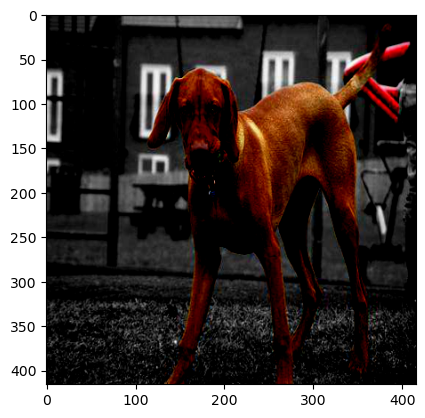

vizsla


In [4]:
# 输出图片
for step, (x, y) in enumerate(train_dataset):
    print(x.shape)
    plt.imshow(x.permute(1, 2, 0))
    plt.show()
    print(label_index_convert.index_to_label[y.item()])
    break

In [5]:
# 使用dataloader
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
# 训练函数  验证函数
def train(model, train_loader, val_loader, optimizer, loss_func, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        with tqdm(total=len(train_loader)) as pbar:
            for step, (x, y) in enumerate(train_loader):
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                loss = loss_func(y_pred, y)
                avg_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.set_description('epoch %d' % epoch)
                pbar.set_postfix(steps=step, loss=loss.item())
                pbar.update(1)
        print('epoch %d avg_loss:' % epoch, avg_loss / len(train_loader))
        val(model, train_loader, mode='train')
        val(model, val_dataloader, mode='val')


def val(model, val_dataloader, mode='val'):
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_count = 0
        for step, (x, y) in enumerate(val_dataloader):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1)
            total_correct += torch.sum(y_pred == y).item()
            total_count += len(y)
        print(mode + ' val acc:', total_correct / total_count)


# 预测函数
def predict(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        result = []
        for step, (x, y) in enumerate(test_dataloader):
            x = x.to(device)
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1)
            result.extend(y_pred.cpu().numpy())
    return result

In [1]:
# 训练模型
# from model.FirstModel import FirstModel
# from model.common.yolov3backbone import V3Backbone
from model.yolov3 import YoloV3
from torch import optim
from torch import nn

model = YoloV3()
# model = model.to("cuda:0")
# summary(model, (3, 416, 416),device="cuda")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

train(model, train_dataloader, val_dataloader, optimizer, loss_func, epochs=100)

NameError: name 'device' is not defined

In [ ]:
train(model, train_dataloader, val_dataloader, optimizer, loss_func, epochs=200)